In [1]:
import fsspec
import concurrent.futures
import obspy as obs
import numpy as np
import multiprocessing as mp
import soundfile as sf

from datetime import datetime
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# WORKHORSE CODE FOR PROCESSING HYDROPHONE SO WE DON'T HAVE TO WORRY ABOUT INSTALLING NON PYPI PACKAGES
def _map_concurrency(func, iterator, args=(), max_workers=-1, verbose=False):
    # automatically set max_workers to 2x(available cores)
    if max_workers == -1:
        max_workers = 2 * mp.cpu_count()

    results = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Start the load operations and mark each future with its URL
        future_to_url = {executor.submit(func, i, *args): i for i in iterator}
        # Disable progress bar
        is_disabled = not verbose
        for future in tqdm(
            concurrent.futures.as_completed(future_to_url), total=len(iterator), disable=is_disabled
        ):
            data = future.result()
            results.append(data)
    return results


class HydrophoneDay:

    def __init__(
        self,
        refdes,
        str_date,
        data=None,
        mseed_urls=None,
        clean_list=None,
        stream=None,
        spec=None,
    ):
        self.refdes = refdes
        self.date = datetime.strptime(str_date, "%Y/%m/%d")
        self.data = data
        self.mseed_urls = self.get_mseed_urls(str_date, refdes)
        self.clean_list=clean_list
        self.stream=stream
        self.spec=spec
        self.file_str = f"{self.refdes}_{self.date.strftime('%Y_%m_%d')}"


    def get_mseed_urls(self, day_str, refdes):

        base_url = "https://rawdata.oceanobservatories.org/files"
        mainurl = f"{base_url}/{refdes[0:8]}/{refdes[9:14]}/{refdes[15:27]}/{day_str}/"
        FS = fsspec.filesystem("http")
        print(mainurl)
    
        try:
            data_url_list = sorted(
                f["name"]
                for f in FS.ls(mainurl)
                if f["type"] == "file" and f["name"].endswith(".mseed")
            )
        except Exception as e:
            print("Client response: ", e)
            return None
    
        if not data_url_list:
            print("No Data Available for Specified Time")
            return None
    
        return data_url_list

    
    def read_and_repair_gaps(self, fill_value, method, wav_data_subtype):
        self.clean_list = _map_concurrency(
            func=self._deal_with_gaps_and_overlaps, 
            args=(fill_value, method, wav_data_subtype), 
            iterator=self.mseed_urls, verbose=False
        )
        
            
    def _merge_by_timestamps(self, st):
        cs = st.copy()
        
        data = []
        for tr in cs:
            data.append(tr.data)
        data_cat = np.concatenate(data)
    
        stats = dict(cs[0].stats)
        stats["starttime"] = st[0].stats["starttime"]
        stats["endtime"] = st[-1].stats["endtime"]
        stats["npts"] = len(data_cat)
    
        cs = obs.Stream(traces=obs.Trace(data_cat, header=stats))
    
        return cs
        

    def _deal_with_gaps_and_overlaps(self, url, fill_value, method, wav_data_subtype):
        if wav_data_subtype not in ["PCM_32", "FLOAT"]:
            raise ValueError("Invalid wav data subtype. Please specify 'PCM_32' or 'FLOAT'")
        # first read in mseed
        if wav_data_subtype == "PCM_32":
            st = obs.read(url, apply_calib=False, dtype=np.int32)
        if wav_data_subtype == "FLOAT":
            st = obs.read(url, apply_calib=False, dtype=np.float64)
        
        
        trace_id = st[0].stats["starttime"]
        print("total traces before concatenation: " + str(len(st)), flush=True)
        # if 19.2 samples +- 640 then concat
        samples = 0
        for trace in st:
            samples += len(trace)
            
        if 19199360 <= samples <= 19200640: # CASE A: just jitter, no true gaps
            print(f"There are {samples} samples in this stream, Simply concatenating")
            cs = self._merge_by_timestamps(st)
            print("total traces after concatenation: " + str(len(cs)))
        else:
            print(f"{trace_id}: there are a unexpected number of samples in this file. Checking for large gaps:")
            gaps = st.get_gaps()
            st_contains_large_gap = False
            # loop checks for large gaps
            for gap in gaps:
                if abs(gap[6]) > 0.02: # the gaps 6th element is the gap length 
                    st_contains_large_gap = True
                    break
            
            if st_contains_large_gap: # CASE B: - edge case - large gaps that should be filled using obspy fill_value and method of choice
                print(f"{trace_id}: there is a gap not caused by jitter. Using obspy method={method}, fill_value={str(fill_value)}")
                cs = st.merge(method=method, fill_value=fill_value)
                print("total trace after merge: " + str(len(cs)))
            else: # CASE C: shortened trace before divert with no large gaps
                print(f"{trace_id}: This file is short but only contains jitter. Simply concatenating")
                cs = self._merge_by_timestamps(st)
                print("total traces after concatenation: " + str(len(cs)), flush=True)
        return cs

In [3]:
# First lets see the behavior of FLAC with different fill values
test_url = "https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2024/11/11/OO-HYEA1--YDH-2024-11-11T00:55:00.000000Z.mseed"

In [4]:
test_st = obs.read(test_url, apply_calib=False, dtype=np.float64)

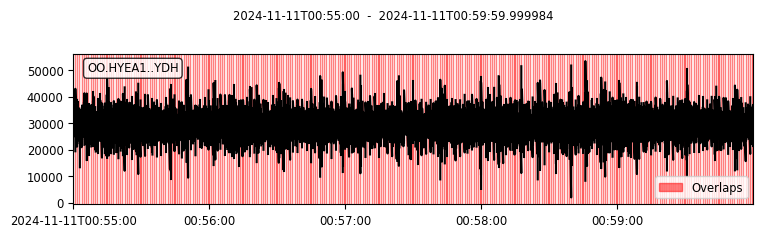

In [5]:
_ = test_st.plot()

In [6]:
# we are going to normalize so we can listen in audacity
norm_st = test_st.normalize()

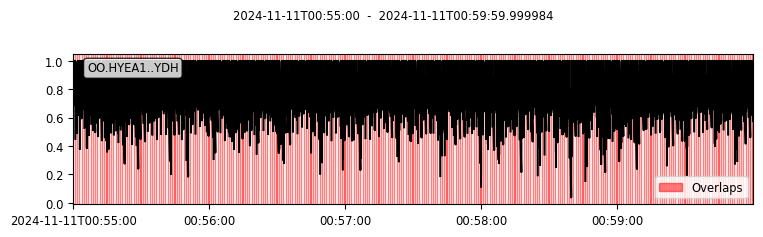

In [7]:
_ = norm_st.plot()

In [8]:
fill_value="interpolate" # can set to any arbitrary value, or np.nan, or "interpolate"
# Note that when set to zero, np,nan or an arbitrary value the listening experience is jarrying
# because the fragmentation/jitter has not been repaired, "interpolate" sounds fine however

In [9]:
merged_st = norm_st.merge(method=0, fill_value=fill_value)

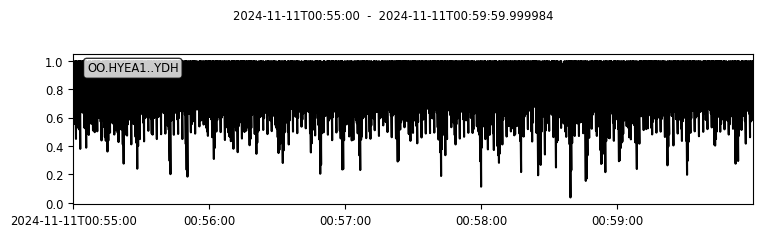

In [10]:
_ = merged_st.plot()

In [11]:
array = merged_st[0].data.copy()

In [12]:
# This section inserts 1 second nan periods into the file - to demonstrate that you can write FLAC with nan
array_length = 19200000
section_size = 64000

# Iterate over the array to set every other section of 64,000 samples to np.nan
for i in range(0, array_length, 2 * section_size):
    array[i + section_size: i + 2 * section_size] = np.nan

In [13]:
# just a reminder that only certain data subtypes are available to write to FLAC
sf.available_subtypes('FLAC')

{'PCM_S8': 'Signed 8 bit PCM',
 'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM'}

In [14]:
# create a directory for our test flac file 
test_dir = "flac_testing"
dir_path = Path.cwd() / test_dir
dir_path.mkdir(exist_ok=True)
file_path = dir_path / "fill_test.flac"

sf.write(file_path, array, 64000, subtype="PCM_24")

## FLAC, WAV and preserving signal integraty

In [15]:
def convert_mseed_to_wav(
    hyd_refdes,
    date,
    fill_value,
    method,
    sr,
    wav_data_subtype,
    normalize_traces,
):
    hyd = HydrophoneDay(hyd_refdes, date)

    hyd.read_and_repair_gaps(fill_value=fill_value, method=method, wav_data_subtype=wav_data_subtype)

    # make dirs 
    date_str = datetime.strftime(hyd.date, "%Y_%m_%d")
    wav_dir = Path(f'./acoustic/wav/{date_str}')
    wav_dir.mkdir(parents=True, exist_ok=True)
    
    for st in hyd.clean_list:
        start_time = str(st[0].stats['starttime'])
        end_time = str(st[0].stats['endtime'])
        dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S.%fZ")
      
        new_format = dt.strftime("%Y%m%d_%H%M%S")#dt.strftime("%y%m%d%H%M%S%z")

        if wav_data_subtype == 'FLOAT':
            st[0].data = st[0].data.astype(np.float64) 
            
        if normalize_traces:
            st = st.normalize()
            
        print(type(st[0].data[0]))
    
        wav_path = wav_dir / f"{hyd_refdes[-9:]}_{new_format}.wav"
        print(str(wav_path))
    
        sf.write(wav_path, st[0].data, SR, subtype=wav_data_subtype) # use sf package to write instead of obspy

    return hyd

In [16]:
HYD_REFDES = "CE04OSBP-LJ01C-11-HYDBBA105"
DATE = "2024/11/11"
FILL_VALUE = 0 # cannot be np.nan for int32
METHOD = 1
SR = 64000
WAV_DATA_SUBTYPE = "PCM_32" #"PCM_24"#'PCM_32' # "FLOAT"  #audacity uses normalized float
NORMALIZE_TRACES = False # True if you want to use float32 for audacity

In [17]:
hyd = convert_mseed_to_wav(
    hyd_refdes=HYD_REFDES,
    date=DATE,
    fill_value=FILL_VALUE,
    method=METHOD,
    sr=SR,
    wav_data_subtype=WAV_DATA_SUBTYPE,
    normalize_traces=NORMALIZE_TRACES,
)

https://rawdata.oceanobservatories.org/files/CE04OSBP/LJ01C/11-HYDBBA105/2024/11/11/
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream, Simply concatenating
total traces after concatenation: 1
total traces before concatenation: 601
There are 19200000 samples in this stream,

In [19]:
# lets take an example repaired mseed stream
hyd.clean_list[0]

1 Trace(s) in Stream:
OO.HYEA1..YDH | 2024-11-11T01:50:00.000000Z - 2024-11-11T01:54:59.999984Z | 64000.0 Hz, 19200000 samples

In [20]:
example_datetime = hyd.clean_list[0][0].stats.starttime

In [21]:
example_time = example_datetime.strftime("%Y%m%d_%H%M%S")

In [22]:
print(example_time)

20241111_015000


In [23]:
# extract the data array from that repaired mseed
mseed = hyd.clean_list[0][0].data

In [54]:
# make dirs 
date_str = datetime.strftime(hyd.date, "%Y_%m_%d")
wav24_dir = Path(f'./acoustic/wav_24bit/{date_str}')
wav_dir = Path(f'./acoustic/wav/{date_str}')
flac_dir = Path(f'./acoustic/flac/{date_str}')
out_dir = Path(f'./acoustic/decoded/{date_str}')
wav24_dir.mkdir(parents=True, exist_ok=True)
wav_dir.mkdir(parents=True, exist_ok=True)
flac_dir.mkdir(parents=True, exist_ok=True)
out_dir.mkdir(parents=True, exist_ok=True)

In [24]:
# now load in the equililant wav file WARNING!!! example_time variable has to be set manually above 
# because we used multithreading to process hyd data
wav, sr = sf.read(f'acoustic/wav/2024_11_11/HYDBBA105_{example_time}.wav', dtype='int32')

In [56]:
# sound files available WAV subtypes
sf.available_subtypes('WAV')

{'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'FLOAT': '32 bit float',
 'DOUBLE': '64 bit float',
 'ULAW': 'U-Law',
 'ALAW': 'A-Law',
 'IMA_ADPCM': 'IMA ADPCM',
 'MS_ADPCM': 'Microsoft ADPCM',
 'GSM610': 'GSM 6.10',
 'G721_32': '32kbs G721 ADPCM',
 'NMS_ADPCM_16': '16kbs NMS ADPCM',
 'NMS_ADPCM_24': '24kbs NMS ADPCM',
 'NMS_ADPCM_32': '32kbs NMS ADPCM',
 'MPEG_LAYER_III': 'MPEG Layer III'}

In [59]:
# per Orest - we will convert wav 32bit to wav 24bit and then load the 24 bit data back into mem
sf.write(f'acoustic/wav_24bit/2024_11_11/HYDBBA_{example_time}.wav', wav, sr, subtype="PCM_24")
wav24, sr24 = sf.read(f'acoustic/wav_24bit/2024_11_11/HYDBBA_{example_time}.wav', dtype='int32')

In [25]:
# wav data
wav

array([29766, 29589, 28503, ..., 28784, 29396, 30391], dtype=int32)

In [60]:
# wav data after being converted to PCM_24
wav24

array([29696, 29440, 28416, ..., 28672, 29184, 30208], dtype=int32)

In [61]:
# mseed data
mseed

array([29766, 29589, 28503, ..., 28784, 29396, 30391], dtype=int32)

In [62]:
# ratio between wav and mseed
wav_mseed_ratio = wav / mseed

In [63]:
# mean should be exactly one if the signal is unchanged!!
np.mean(wav_mseed_ratio)

np.float64(1.0)

In [64]:
# we convert int32 wav to int24 flac by using soundfile
for wav_path in wav_dir.glob('*.wav'):
    data, sr = sf.read(wav_path, dtype='int32') #tell the reader that datatype is int32
    
    flac_path = flac_dir / wav_path.with_suffix('.flac').name
    
    sf.write(flac_path, data, sr, subtype="PCM_24") # int32 is not supported for sf.write -> FLAC so we will use int24
    print(f'Converted {wav_path} to {flac_path}')

Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_193500.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_193500.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_220000.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_220000.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_093500.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_093500.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_224500.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_224500.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_085000.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_085000.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_081500.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_081500.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_232000.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_232000.flac
Converted acoustic/wav/2024_11_11/HYDBBA105_20241111_185000.wav to acoustic/flac/2024_11_11/HYDBBA105_20241111_185000.flac
Converted acoust

In [65]:
# lets read flac back into memory specifying int32 (we don't want the reader to default to float, int24 is not supported
flac, sr = sf.read(f'acoustic/flac/2024_11_11/HYDBBA105_{example_time}.flac', dtype="int32")

In [66]:
flac

array([29696, 29440, 28416, ..., 28672, 29184, 30208], dtype=int32)

In [67]:
# looks like Orest was right, the conversion between datatypes, not filetypes is causing the difference 
# the data that has been converted to 24bit flac and 24bit wav are identical
flac / wav24

array([1., 1., 1., ..., 1., 1., 1.])

In [68]:
wav / wav24

array([1.00235722, 1.00506114, 1.00306166, ..., 1.00390625, 1.00726425,
       1.006058  ])

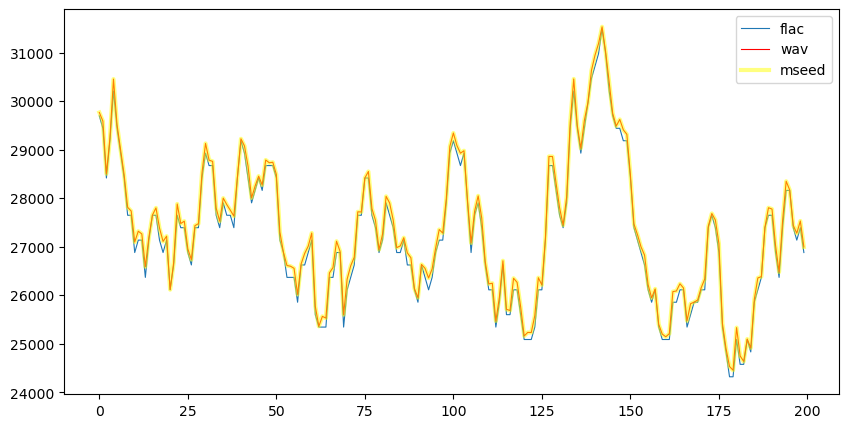

In [51]:
fig = plt.figure(figsize=(10, 5))
plt.plot(flac[:200], linewidth=0.8, label="flac")
plt.plot(wav[:200], linewidth=0.8, label="wav", color="red")
plt.plot(mseed[:200], linewidth=3, alpha=0.5, label="mseed", color="yellow")
plt.legend()

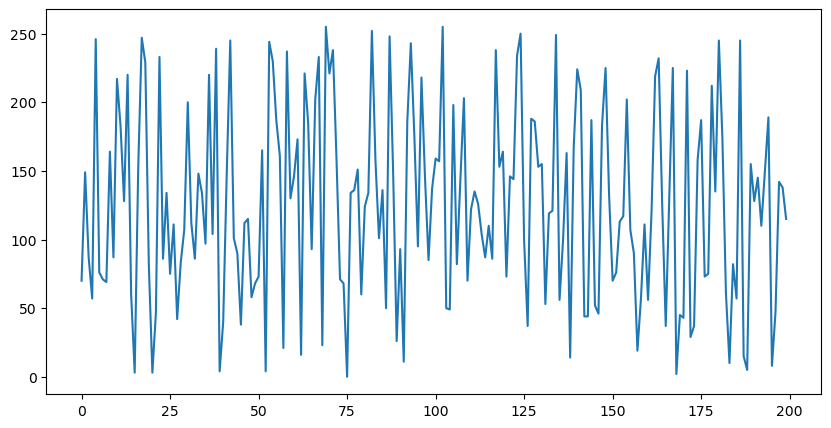

In [40]:
fig = plt.figure(figsize=(10, 5))
plt.plot(wav[:200] - flac[:200])

In [41]:
# close but not quite
wav / flac

array([1.00235722, 1.00506114, 1.00306166, ..., 1.00390625, 1.00726425,
       1.006058  ])

In [42]:
# mean
np.mean(wav / flac)

np.float64(1.004420617088259)